# Layerwise Clustering

The particles used throughout the study include the depth level.
In this notebokook we investigate the difference of VOCC used for all particles without the depth information and VOCC used for the top 30 meters.
In the surface the rotation velocities are the highest and the features should be better recognizable.

In [1]:
from VoCC import VortexCorrelationClustering
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score
from py_eddy_tracker.dataset.grid import UnRegularGridDataset
from datetime import datetime

%run ../scripts/experiment_utils.py

MIN_PARTICLES = 40

In [2]:
coordinates = np.load('../data/particles_29102011_depth.npy')
X,Y,U,V,D = coordinates.T

# The magnitude of the movement are two days we normalize them to one.
U /= 2
V /= 2
# Set outliers to zero
U[U > 1] = 0
V[V > .5] = 0

In [3]:
# Get the py-eddy-tracker labels
def extract_lagrangian_eddies(eddy_dataset, particles_x, particles_y, particle_threshold):
    counts, _ = np.histogram(eddy_dataset.contains(particles_x, particles_y), bins = np.arange( len(eddy_dataset)+1))
    mask_indices = np.argwhere(counts >= particle_threshold).squeeze()

    mask = np.zeros(len(eddy_dataset.obs), dtype=bool)
    mask[mask_indices] = True

    return eddy_dataset.extract_with_mask(mask)


def get_py_eddy_tracker_labels():
    g = UnRegularGridDataset('../data/ssh_u_v_1d_20111029.nc',
                        'nav_lon', 'nav_lat', centered=True)
    g.high_filter('ssh',w_cut=700,factor=8.0)
    date = datetime(2011,10,29)
    a,c = g.eddy_identification('ssh', 'u', 'v', date = date, step=0.004, shape_error=70)


    # Load the particles dataset

    coordinates = np.load('../data/particles_29102011.npy')
    X,Y,U,V = coordinates[::3].T

    # The magnitude of the movement are two days we normalize them to one.
    U /= 2
    V /= 2
    # Set outliers to zero
    U[U > 1] = 0
    V[V > .5] = 0

    particle_eddy_a = extract_lagrangian_eddies(a, X, Y, MIN_PARTICLES).contains(coordinates[:,0],coordinates[:, 1])
    particle_eddy_c = extract_lagrangian_eddies(c, X, Y, MIN_PARTICLES).contains(coordinates[:,0],coordinates[:, 1])

    particle_eddy_c[particle_eddy_c >= 0] += particle_eddy_a.max() +1

    particle_eddy_labels = np.max(np.vstack((particle_eddy_a, particle_eddy_c)), axis = 0)
    return particle_eddy_labels, a, c

particle_eddy_labels, a, c = get_py_eddy_tracker_labels()

## VoCC clusters without depth information

In [4]:
vocc = VortexCorrelationClustering(
    radii=np.arange(4,24,4),
    cell_size= .07, 
    sectors = 15, 
    circle_coverage_rate = .75, 
    qth_threshold = .99, 
    min_points = .01
)
labels_all_layers = vocc.fit(coordinates).labels_

<GeoAxes: >

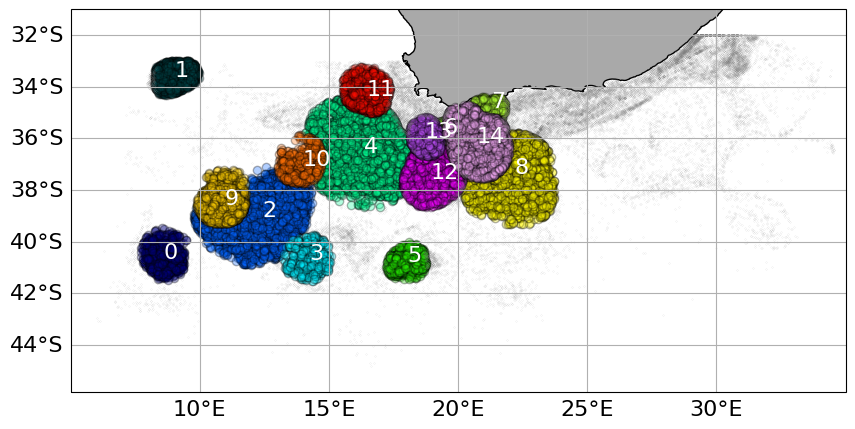

In [5]:
create_real_world_image(coordinates, labels_all_layers, 'VoCC-61-all-layers-bla', True)

## First 30 meter 

In [6]:
surface_mask = (D < - 30)

vocc = VortexCorrelationClustering(
    radii=np.arange(4,24,4),
    cell_size= .07, 
    sectors = 15, 
    circle_coverage_rate = .75, 
    qth_threshold = .99, 
    min_points = .01
)
labels_surface = vocc.fit(coordinates[surface_mask]).labels_

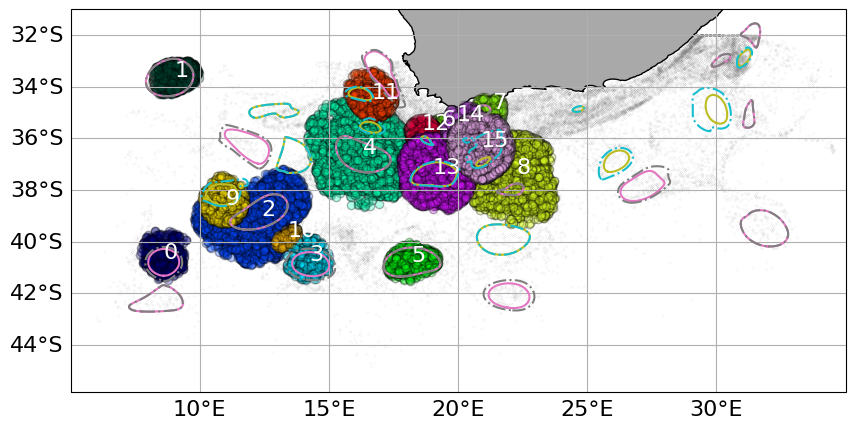

In [7]:
ax = create_real_world_image(coordinates[surface_mask], labels_surface, 'VoCC-61-surface-30m', True)
from cartopy.crs import PlateCarree 
extract_lagrangian_eddies(a, X, Y, MIN_PARTICLES).display(ax, transform = PlateCarree())
extract_lagrangian_eddies(c, X, Y, MIN_PARTICLES).display(ax, transform = PlateCarree())

If we only take the surface layers we detect eddies near the coast that are not visible in the pyeddtracker. The lesser density of particles lead the VoCC algorithm to find local extrema in such regions.

In [8]:
mask = particle_eddy_labels > -1

print('without noise')
print(f'all layers vs. py-eddy-tracker: {adjusted_rand_score(particle_eddy_labels[mask], labels_all_layers[mask]):.3f}')
print(f'surface vs. py-eddy-tracker: {adjusted_rand_score(particle_eddy_labels[surface_mask][mask[surface_mask]], labels_surface[mask[surface_mask]]):.3f}')

print('all particles')
print(f'all layers vs. py-eddy-tracker: {adjusted_rand_score(particle_eddy_labels, labels_all_layers):.3f}')
print(f'surface vs. py-eddy-tracker: {adjusted_rand_score(particle_eddy_labels[surface_mask], labels_surface):.3f}')

without noise
all layers vs. py-eddy-tracker: 0.911
surface vs. py-eddy-tracker: 0.937
all particles
all layers vs. py-eddy-tracker: 0.198
surface vs. py-eddy-tracker: 0.212
